_Kamal Bentahar_ (individual work)

[https://github.coventry.ac.uk/ab3735/380CT/tree/master/SAT](https://github.coventry.ac.uk/ab3735/380CT/tree/master/SAT)

_This is a guide report for the 380CT Assignment._

# Notation

Let $x_1,x_2,\ldots,x_n$ be Boolean **variables**, and let $\phi$ be a Boolean formula written in 3-cnf (Conjunctive Normal Form) given by
	$$
	\phi = c_1\land c_2\land \cdots \land c_\ell,
	$$
where each **clause** $c_m$ has the form $\alpha\lor \beta \lor \gamma$, where each of $\alpha, \beta, \gamma$ is a **literal**: a variable $x_i$ or its _negation_ $\bar x_i$.


The ratio $\ell/n$ is important for experiments, and will be denoted by $\rho$.

# Definition of the problem

Given $\phi$ as above, the versions of the 3SAT are defined as follows:

* **Decisional 3SAT**:

    _Decide if $\phi$ is satisfiable._

    **NP-complete**, because 3SAT $\in$ NP and SAT $\leq_p$ 3SAT.
    
    * 3SAT $\in$ NP: once an assignment of the variables is given (a certificate) we can quickly evaluate $\phi$ in $O(\ell)$ time to verify it.
    * SAT $\leq_p$ 3SAT: Reduction from the SAT problem, which is known to be NP-complete by the Levin-Cook theorem (Sipser, 2013, p. 304).

* **Computational/Search 3SAT**:

    _If $\phi$ is satisfiable then find a satisfying assignment._

    **NP-Hard**, because we can reduce the decision version of 3SAT to it trivially: if a solution is found then return **yes**, otherwise return **no**.

* **Optimization 3SAT (Max 3SAT)**:

    _Find an assignment that minimizes the number of non-satisfying clauses._

    **NP-Hard**, because the optimization version of (decision) NP-complete problems are automatically NP-Hard. (using the same method sketched above for **Search 3SAT**)

The facts about the complexity classes memberships can also be found in (Garey and Johnson, 1979).

# Testing methodology

* **Exhaustive search**:
    average time for instances with increasing $n$.
* **Dynamic programming**:
    average time for instances with increasing $\ell$.
* **Greedy and meta-heuristics**:
    quality of approximation with increasing $\rho$ . Quality of approximation is calculated as the ratio of satisfied clauses to $\ell$.


## Random instances sampling strategy

Following (Hoos & Stutzler, 2005), general 3SAT instances will be generated by selecting exactly 3 different literals from
$$\{x_1, \bar x_1, x_2, \bar x_2, \ldots, x_n, \bar x_n\}$$
uniformly at random.

Do not allow clauses including both $x_i$ and $\bar x_i$ (tautological clauses).


For *yes* instances, a random variable assignment is fixed first, then clauses are randomly constructed making sure each is satisfiable.


# Code

First start by importing relevant libraries.

In [19]:
from random    import sample, choice, shuffle, randint
from itertools import product
from numpy     import arange
from time      import time
import matplotlib.pyplot as plt

## Base class definition

In [20]:
class SAT():
    def __init__(self):
        ''' Initialize an empty 3SAT instance: phi '''
        self.variables = []     # Names of the variables :1,2,... -> x1,x2,...
        self.clauses   = []     # Clauses, e.g. [1,2,-3]  -> x1 and x2 and not x3
        self.nv        = 0      # Number of variabes = len(self.variables)
        self.nc        = 0      # Number of clauses  = len(self.clauses)
        self.configuration = [] # Current value assignment of the variabes

In [21]:
def sat_repr(self):
    ''' To print out the SAT instance in readable form '''
    r  = "SAT instance with "+str(self.nv)
    r += " variables and "+str(self.nc)+" clauses: \n"
    for c in self.clauses:
        r+= str(c) + "\n"
    return r
SAT.__repr__ = sat_repr

In [22]:
def set_variable(self, variable, value):
    ''' Set the given 'variable' to the giben  'value' '''
    self.configuration[ abs(variable)-1 ] = value
def flip_variable(self,variable):
    '''
    Flip the value of 'variable'
    '''
    idx = abs(variable)-1
    self.configuration[ idx ] = not self.configuration[ idx ]
def get_variable(self,variable):
    ''' Return the value assigned to 'variable' '''
    return self.configuration[ abs(variable)-1 ]

SAT.set_variable = set_variable
SAT.flip_variable = flip_variable
SAT.get_variable = get_variable

## Evaluation

In [23]:
def clause_value(self, clause):
    ''' Return the value of 'clause' '''
    x1 = self.get_variable( clause[0] )
    x2 = self.get_variable( clause[1] )
    x3 = self.get_variable( clause[2] )
    # if negative then negate boolean value of the variable
    if clause[0]<0: x1 = not x1
    if clause[1]<0: x2 = not x2
    if clause[2]<0: x3 = not x3
    return (x1 or x2 or x3)

def value(self):
    ''' evaluate phi - stop as soon as a clause is False '''
    for c in self.clauses:
        # if any clause is False then phi is not satisfied
        if self.clause_value( c ) == False:
            return False
    # if no clause is False then phi is satisfied
    return True                             

def value_full(self):
    ''' evaluate phi - do not stop until we evalaute all clauses '''
    val = True
    for c in self.clauses:
        val &= self.clause_value( c )
    return val

def ratio_unsatisfied(self):
    ''' calculate ratio of satisfied clauses '''
    count = 0
    for c in self.clauses:
        if self.clause_value( c ) == False:
            count += 1
    return count/self.nc

SAT.clause_value = clause_value
SAT.value = value
SAT.value_full = value_full
SAT.ratio_unsatisfied = ratio_unsatisfied

## Methods for random constructions

In [24]:
def random_clause(self):
    ''' helper function to generate a clause randomly '''
    c = sample(self.variables,3)
    c[0] *= choice([-1,1])
    c[1] *= choice([-1,1])
    c[2] *= choice([-1,1])
    return c

def random_instance(self, nv, nc):
    ''' build a random 3SAT instance with nv variables and nc clauses '''
    self.nv = nv
    self.variables = list(range(1,nv+1))
    self.configuration = [False]*nv
    self.nc = nc
    # generate nc clauses: (... or ... or ...)
    self.clauses = []
    for c in range(nc):
        self.clauses.append( self.random_clause() )

def random_configuration(self):
    '''
    Build a random configuration (= assignment of the variables)
    Return value of objective function.
    '''
    self.configuration = [choice([True,False]) for nv in range(self.nv)]

def random_yes_instance(self, nv, nc):
    ''' build a random 'yes' 3SAT instance with nv variables and nc clauses '''
    # choose a random configuration to be satisfied
    self.nv = nv
    self.variables = list(range(1,nv+1))
    self.random_configuration()
    # choose satisfying clauses
    self.nc = nc
    self.clauses = []
    for nc in range(self.nc):
        c = self.random_clause() #sample(self.variables,3)
        # alter c until it becomes satisfying
        while self.clause_value(c) == False:
            c[ choice([0,1,2]) ] *= -1  # by flipping terminals (negating)
        self.clauses.append(c)
    if self.value() != True:
        print("something has gone wrong!")

SAT.random_clause = random_clause
SAT.random_instance = random_instance
SAT.random_configuration = random_configuration
SAT.random_yes_instance = random_yes_instance

# Solution methods

## Exact methods -- Exhaustive search

Pseudo-code:

1. **for all** possible variable assignments of $x_1,x_2,\ldots,x_n$ **do**
2. $\quad$ **if** $\phi(x_1,x_2,\ldots,x_n)$ evaluates to True **then**
3. $\qquad$ **return** True
4. $\quad$ **end if**
5. **end for**
6. **return** False

There are $2^n$ possible assignments, and each  evaluation of $\phi$ costs $O(\ell)$. So this algorithm costs $$O(\ell\, 2^n).$$

In [25]:
def exhaustive_search(self):
    '''
    Solve in the 3SAT problem instance using exhaustive search
    -- stop as soon as a solution is found
    '''
    # iterate over all the possible Boolean variable assignments
    for self.configuration in product([True,False],repeat=self.nv):
        if self.value() == True:
            return True
    return False

def exhaustive_search_full(self):
    ''' Solve in the 3SAT problem instance using exhaustive search '''
    # iterate over all the possible Boolean variable assignments
    self.decision = False
    for self.configuration in product([True,False],repeat=self.nv):
        # if any configuration satisfies it then we get True
        self.decision |= self.value_full()
    return self.decision

SAT.exhaustive_search = exhaustive_search
SAT.exhaustive_search_full = exhaustive_search_full

## Testing

Average time for randomly generated instances with $\rho=3$.

In [26]:
instance = SAT() # global variable... [TODO?]
pnts_n = []
pnts_t = []
def time_Exhaustive():
    # test exhaustive search
    print("n\tExhaustive" ) # header
    max_repeats = 100
    n  = 10
    t0 = t1 = 0
    while t1-t0<60: # in seconds; if it takes too long then stop testing
        t0 = time()
        for repeats in range(max_repeats): # e.g. average over 100 instances
            instance.random_yes_instance(n,3*n) # rho=3
            decision = instance.exhaustive_search()
        t1 = time()
        # record average time
        print( str(n)+"\t"+str((t1-t0)/max_repeats) )
        pnts_n.append( n )
        pnts_t.append( (t1-t0)/max_repeats )
        n += 1
time_Exhaustive()

n	Exhaustive
10	0.0016361308097839356
11	0.002511744499206543
12	0.004523138999938964
13	0.009381508827209473
14	0.017256977558135985
15	0.02649304151535034
16	0.054238312244415283
17	0.07540356397628784
18	0.1821987247467041
19	0.4292074728012085
20	0.6677624154090881


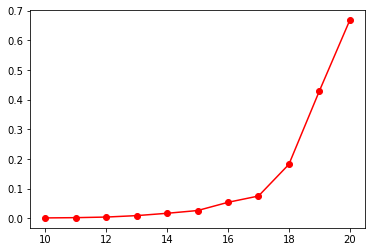

In [27]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

In [28]:
import numpy as np
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x * (2 ** x) + b

popt, pcov = curve_fit(func, pnts_n, pnts_t)

In [29]:
str(popt[0])+" * n * 2^n + "+str(popt[1])

'3.31991597899e-08 * n * 2^n + 0.0134577258739'

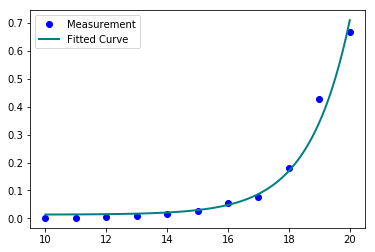

In [30]:
x = pnts_n
y = pnts_t
plt.figure()
plt.plot(x, y, 'bo', label="Measurement")
xx = np.linspace(pnts_n[0],pnts_n[-1],100)
plt.plot(xx, func(xx, *popt), 'r-',
         linewidth=2, color='teal', label="Fitted Curve")
plt.legend(loc='best')
plt.show()

### Discussion

* Exhaustive search exhibits exponential running time:
    linear in $\ell$ but exponential in $n$.

* So it is useful when $n$ is small even if $\ell$ is large.

# Approximation

## Greedy

Find the variable that appears most often and assign it accordingly to
maximize the number of satisfied clauses.


1. $L \gets \emptyset$
2. **for** $w\in\{x_1,\bar x_1,\ldots,x_n,\bar x_n\}$ **do**
3. $\quad$ Count occurrences of $w$ in $\phi$
4. $\quad$ Append pair ($w$, count of occurrences of $w$ in $\phi$) to $L$
5. **end for**
6. Sort $L$ with respect to the second component
    Comment: We now have the literals in decreasing order of total occurrence
7. **for all** $(w,c)\in L$ **do**
8. $\quad$ Set $w$ to True $\quad$ (i.e. if $w=\bar x_i$ then set $x_i$ to False)
9. **end for**
10. **return** count of satisfied clauses

##### Cost
Steps 1-5 and 7-10 are $O(n)$, and step 6 costs $O(n\log n)$ assuming the use of an $O(n\log n)$ sorting
algorithm.

The total costs is the sum of these three sequential blocks, yielding a total cost of: $$(n \log n)$$

In [31]:
def greedy(self):
    '''
    Solve in the 3SAT problem instance using a simple greedy search.
    Find the variable that appears most often and assign it accordingly
    '''
    literals_occurance = [[i,0] for i in range(-self.nv,self.nv+1)]
    for c in self.clauses:
        for v in c:
            literals_occurance[ v+self.nv ][1] += 1
    literals_occurance.sort( key=lambda a:a[1] )
    for v in literals_occurance:
        self.set_variable( v[0] , v[0]>0 )
    return self.ratio_unsatisfied()

SAT.greedy = greedy

## Greedy Randomized Adaptive Search Procedure (GRASP)

The general template pseudocode for GRASP is given by:

1. $best\_candidate\gets \emptyset$
2. **while** "termination condition" is not met **do**
3.  $\quad$ $greedy\_candidate\gets \text{ConstructGreedyRandomizedSolution}()$
4.  $\quad$ $grasp\_candidate\gets \text{LocalSearch}(greedy\_candidate)$
5.  $\quad$ **if** $f(grasp\_candidate) < f(best\_candidate)$ **then**
6.  $\qquad$  $best\_candidate\gets grasp\_candidate$
7.  $\quad$ **end if**
8. **end while**
9. **return** $best\_candidate$

For our problem, we have:

-   **termination condition** is simply to repeat a fixed number of times, e.g. 100 times.

-   $f$ gives the ratio of unsatisfied clauses to $\ell$. Objective is to minimize it.

-   **ConstructGreedyRandomizedSolution()** works like Greedy but shuffles $L$ in blocks of a given size. \[TODO: EXPLAIN MORE\]

-   **LocalSearch()** works by flipping one variable's assignment at a time, and seeing if $f$ improves. The best improvement is selected after trying all of them. [@greedy]

In [32]:
def greedy_randomized(self, block_size=2):
    '''
    Solve in the 3SAT problem instance using a randomized greedy search
    Find the variable that appears most often and assign it accordingly
    Same as greedy() but randomizes the order of 'literals_occurance' a bit
    '''
    literals_occurance = [[i,0] for i in range(-self.nv,self.nv+1)]
    for c in self.clauses:
        for v in c:
            literals_occurance[ v+self.nv ][1] += 1
    literals_occurance.sort( key=lambda a:a[1] )
    # randomize list block by block
    for i in range(0,len(literals_occurance), block_size):
        tmp = literals_occurance[i:i+block_size]
        shuffle( tmp )
        literals_occurance[i:i+block_size] = tmp
    for v in literals_occurance:
        self.set_variable( v[0] , v[0]>0 )
    return self.ratio_unsatisfied()

def GRASP(self, max_repetition=100):
    ''' Solve the 3SAT problem instance using the GRASP meta-heuristic '''
    best = 1 # i.e. start with the worst solution that satisfies no clauses
    for i in range(max_repetition):
        # random block_size from {2,3,4}
        candidate = self.greedy_randomized( choice([2,3,4]) )
        # local search: flip variable assignment and see if things improve
        # Choose the best one from the flipped attempts
        best_v = 0
        for v in self.variables:
            self.flip_variable(v)          # try changing variable v
            neighbour = self.ratio_unsatisfied()
            if neighbour < candidate:
                candidate = neighbour
                best_v = v
            self.flip_variable(v) # undo, to try flipping next variable
        if candidate < best:
            best = candidate
    return best

SAT.greedy_randomized = greedy_randomized
SAT.GRASP = GRASP

## Genetic Algorithm

The general template pseudocode for Genetic Algorithms is given by:

1. determine initial population $p$
2. **while** termination criterion not satisfied **do**
3. $\quad$ generate set $pr$ of new candidate by recombination
4. $\quad$ generate set $pm$ of new candidates from $p$ and $pr$ by mutation
5. $\quad$ select new population $p$ from candidates in $p, pr, pm$
6. **end while**
7. **return** fittest candidate found

For our problem, we have:

-   **Initial population**: generate 20 candidates by randomly assigning True/False values to the variables.
-   **termination criterion** is to simply repeat 20 times.
-   **Recombination** is done by cutting a pair of candidates at some point ($ab$,$cd$) then creating the possible combinations $ad$ and $cb$.
-   Each candidate is **mutated** by flipping one random variable with probability 20%.
-   The candidates are then sorted according to the objective function, and the fittest are kept.

In [33]:
def GA(self, pop_size=20, max_generations=20):
    '''
    Solve the 3SAT problem instance using the Genetic Algorithm meta-heuristic
    '''
    def sort_key(p):
        self.configuration = p
        return self.ratio_unsatisfied()
    population = [
        [choice([True,False]) for nv in range(self.nv)]
            for i in range(pop_size)
    ]
    for generation in range(max_generations):
        # crossing
        for i in range( pop_size ):
            for j in range(i+1, pop_size):
                cut = randint(0,self.nv-1)
                population.append( population[i][:cut] + population[j][cut:] )
                population.append( population[j][:cut] + population[i][cut:] )
        # mutation
        for i in range( len(population) ):
            j = randint(0,self.nv-1) # variable to mutate
            if randint(0,100)<=20:   # probabilistically mutate
                population[i][j] = not population[i][j]
        # choose fittest
        population.sort(key=sort_key)
        population = population[:pop_size]
        self.configuration = population[0]
    return self.ratio_unsatisfied()

SAT.GA = GA

## Testing

In [34]:
instance = SAT() # global variable... [TODO?]
pnts_rho = []
pnts_greedy = []
pnts_grasp = []
pnts_ga = []

def test_Approximation():
    print( "rho\tGreedy\tGRASP\tGA" )
    max_repeats = 100
    nv = 20
    for rho in arange(1,10,1):  # rho = nc/nv
        nc = int(rho*nv)
        q = [0]*3        # to measure 'quality'
        for repeat in range(max_repeats):
            instance.random_yes_instance(nv, nc)
            q[0] += instance.greedy()
            q[1] += instance.GRASP()
            q[2] += instance.GA()
        for i in range(3): q[i] = '{:1.4f}'.format(1-q[i]/max_repeats)
        print( str(rho)+'\t'+"\t".join(q) )
        pnts_rho.append( rho )
        pnts_greedy.append( q[0] )
        pnts_grasp.append( q[1] )
        pnts_ga.append( q[2] )

test_Approximation()

rho	Greedy	GRASP	GA
1	0.9835	0.9995	1.0000
2	0.9653	0.9932	1.0000
3	0.9505	0.9788	0.9995
4	0.9451	0.9736	0.9972
5	0.9416	0.9678	0.9943
6	0.9443	0.9665	0.9938
7	0.9364	0.9609	0.9936
8	0.9337	0.9575	0.9921
9	0.9366	0.9589	0.9932


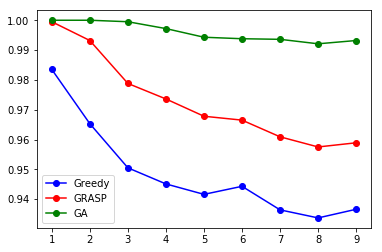

In [35]:
plt.figure()
p1 = plt.plot(pnts_rho, pnts_greedy, 'bo-', label="Greedy")
p2 = plt.plot(pnts_rho, pnts_grasp, 'ro-', label="GRASP")
p3 = plt.plot(pnts_rho, pnts_ga, 'go-', label="GA")
plt.legend(loc='best')
plt.show()

## Discussion

For $1\leq \rho\leq 9$ we notice that:

-   Greedy gets about 94-98% of the clauses satisfied.
-   GRASP improves this to about 97-100%.
-   GA performs better than GRASP at about 99-100%.
-   For all of them, the quality decreases as $\rho$ increases.

# Special cases

* $n=1$.

    Each clause will fall into one of 3 categories as follows:

    1. Only $x$ appears. The clause reduces to: $x\lor x\lor x = x$
    2. Only $\bar x$ appears. The clause reduces to: $\bar x\lor \bar x\lor \bar x = \bar x$.
    3. Both $x$ and $\bar x$ appear. The clause becomes a tautology: $x\lor \bar x \lor \ldots = T$, and the clause can be ignored.

    So $\phi$ simplifies to a conjunction of $x$'s and $\bar x$'s, whose satisfiability is easy to establish:
    * If both $x$ and $\bar x$ appear then return **no**.
    * Otherwise, return **yes**.

* $n=2$.

    We get 2-SAT which is known to be in **P**, (Krom, 1967).

* $\ell=1$.

    Always satisfiable.
    
    [TODO: true for $\ell\leq n$?]

* Nested satisfiability, (Knuth, 1990).

    If the clauses have a "hierarchical structure", as defined in (Knuth, 1990), then it is solvable in linear time.

# Conclusion

* If instance is a special case then can be solved in polynomial time.
* Exhaustive search useful when $n$ is small.
* Dynamic programming useful when $\ell$ is small.
* Otherwise, use GRASP, GA, or other metaheuristics for approximate solutions.

# Reflection

Reflection ....

# References

* Garey, S. and Johnson, D. (1979)
**Computers and Intractability: A Guide to the Theory of NP-Completeness.**
Freeman.

* Hoos, H. and Stutzler, T. (2005)
**Stochastic Local Search: Foundations and Applications.**
Morgan Kaufmann.

* Knuth, D.E. (1990).
**Nested satisfiability.**
Acta Informatica, 28(1), 1-6.

* Koutsoupias, E., & Papadimitriou, C. H. (1992).
**On the greedy algorithm for satisfiability.**
Information Processing Letters, 43(1), 53-55.

* Krom, M.R. (1967).
**The Decision Problem for a Class of First-Order Formulas in Which all Disjunctions are Binary**
Zeitschrift für Mathematische Logik und Grundlagen der Mathematik, 13: 15–20, [doi:10.1002/malq.19670130104](doi:10.1002/malq.19670130104).

* Sipser, M. (2013).
**Introduction to the theory of computation**
(3rd international ed.). Cengage Learning.